In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import skimage.io
import glob
import albumentations as A


# Root directory of the project
ROOT_DIR = os.path.abspath(os.getcwd())

# Import Mask RCNN 
sys.path.append(ROOT_DIR)
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn import model as modellib
from mrcnn.model import log
from mrcnn import stats_utils

import Monuseg_dist

%matplotlib inline 
%load_ext autoreload
%autoreload 2

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

MONUSEG_DIR = os.path.join(ROOT_DIR, "datasets\\Monuseg_dist")
config = Monuseg_dist.MonusegDIST_H_InferenceConfig()


c:\tensorlflow1.14\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\tensorlflow1.14\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\tensorlflow1.14\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\tensorlflow1.14\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' 

In [2]:
# Load dataset - 
subset = "val"
dataset_dir = os.path.join(MONUSEG_DIR, subset)
image_dir = os.path.join(dataset_dir, "tissue_images")
image_ids = os.listdir(image_dir)
print("Found {} images in {}".format(len(image_ids), image_dir))


dataset = Monuseg_dist.MonusegDISTDataset("UNET")
dataset.add_class(source = "Monuseg", class_id =  1, class_name = "nucleus")

# Fill with the samples
i = 0
for _id in image_ids:
    name,_ = os.path.splitext(_id)
    if i <= len(image_ids):
        dataset.add_image(source = "Monuseg",
                                image_id = name,
                                path = os.path.join(image_dir, _id))
    i+=1    

    
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Found 14 images in C:\Users\User\GitHub\Improved Mask R-CNN\datasets\Monuseg_dist\val\tissue_images
Image Count: 14
Class Count: 2
  0. BG                                                
  1. nucleus                                           


In [3]:
# Example Detections from pannuke ensemble
path_list = [
    r"C:\Users\User\GitHub\Improved Mask R-CNN\logs\Fold0\Detections",
    r"C:\Users\User\GitHub\Improved Mask R-CNN\logs\Fold1\Detections",
    r"C:\Users\User\GitHub\Improved Mask R-CNN\logs\Fold2\Detections",
    r"C:\Users\User\GitHub\Improved Mask R-CNN\logs\Fold3\Detections",
    r"C:\Users\User\GitHub\Improved Mask R-CNN\logs\Fold4\Detections"
]
confidence_thresh = 0.7 # Min average confidence of the ensemble for positive pixel segmentation
iou_thresh = 0.7 # Min IoU for matching instances (relatively high)

In [5]:
# Deconstructed Example
_id = 5
img = dataset.load_image(_id)[:,:,0:3]
info = dataset.image_info[_id]
n = info["id"]
print(n)
all_masks = []
# Load exsting detections (float)
for p in path_list:
    m = np.load(os.path.join(p, n + "_masks.npz"))["arr_0"]
    m = m / np.max(m) * 255 # convert to uint8 for memory/performance
    m = m.astype(np.uint8)
    print(m.shape, m.dtype)
    all_masks.append(m)
    
    
all_masks = np.concatenate(all_masks, axis = -1)
print(all_masks.shape)

all_bboxes = utils.extract_bboxes(all_masks > confidence_thresh) # for preliminary bboxes
print(all_bboxes.shape)

TCGA-AO-A0J2-01A-01-BSA
(1000, 1000, 425) uint8
(1000, 1000, 466) uint8
(1000, 1000, 452) uint8
(1000, 1000, 466) uint8
(1000, 1000, 465) uint8
(1000, 1000, 2274)
(2274, 4)


Merged: idx 0 with idxs [ 603  951 1481 1942]
Box coordinates were:
[911 271 935 323]
[[908 270 938 323]
 [909 270 938 322]
 [909 271 938 319]
 [909 270 937 322]]


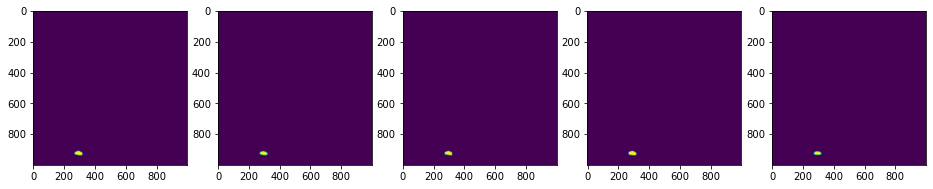

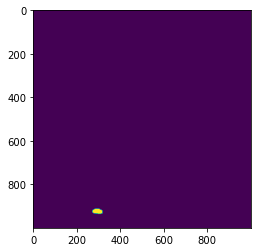

In [7]:
_all_masks = all_masks.copy()
_all_bboxes = all_bboxes.copy()

ret_mask = []
counter = np.array(range(_all_bboxes.shape[0])) # get indices
n = 0
maxi = 1 #_all_bboxes.shape[0]

y1 = _all_bboxes[:, 0]
x1 = _all_bboxes[:, 1]
y2 = _all_bboxes[:, 2]
x2 = _all_bboxes[:, 3]
area = (y2 - y1) * (x2 - x1)

fig, axs = plt.subplots(1,5, figsize = (16,16))

while n < maxi: # Run this example for 1 step (In code go through all bboxes)
    if counter[n] == -1: # If has been matched before - skip
        n+=1
        continue
    else:
        i = counter[n] # Take bbox (-index)
        # Get IoU with all other boxes (skip the first, which we have atm to avoid errors)
        iou = utils.compute_iou(_all_bboxes[i], _all_bboxes[1:], area[i], area[1:]) 
        # Get indices of boxes with iou > thresh, (+1 for skipped box)
        idxs = np.where(iou > iou_thresh)[0] + 1 
        matches = np.append(idxs, counter[0]) # Add current box
        if len(matches) > 2: # If majority of models saw something at this intersection
            inst_mask = all_masks[:,:,matches]
            for ii in range(inst_mask.shape[-1]):
                axs[ii].imshow(inst_mask[:,:,ii])
            # Merge by average voting
            inst_mask = np.mean(inst_mask, axis = -1) > confidence_thresh * 255   
            ret_mask.append(inst_mask)
            print("Merged: idx {} with idxs {}".format(i, idxs))
            print("Box coordinates were:")
            print(_all_bboxes[i])
            print(_all_bboxes[idxs])

        # Set visited boxes to -1, continue
        counter[np.isin(counter, matches)] = -1
    plt.figure()
    plt.imshow(inst_mask)
    n+=1
    
ret_mask = np.array(ret_mask)
ret_mask = ret_mask.transpose(1,2,0)